# Simple convolutional neural network to perform classification.


The project focuses on developing and comparing image classification models using convolutional neural networks (CNNs). First, we build a custom CNN model from scratch, train it on a chosen dataset, and evaluate its performance. Next, we fine-tune two pre-trained state-of-the-art models, such as ResNet or AlexNet, and compare their performance with our custom model.

The goal of this is to understand the trade-offs between designing a CNN from scratch and using pre-trained models through transfer learning. From this we get a chance to explore key concepts like network architecture, activation functions, optimizers, and overfitting, while analyzing how different models handle image classification tasks.

### 1.Import Libraries

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

### 2.Load and Process Data

In [2]:
# Data Pre-processing

# Paths
dataset_path = r'C:\Users\STZ\Downloads\realwaste-main\RealWaste'
base_dir = r'C:\Users\STZ\Downloads\realwaste-main\Splits'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Ratios for splitting the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Ensure directories are clean
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into train, val, and test folders
classes = os.listdir(dataset_path)
for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    train_size = int(len(images) * train_ratio)
    val_size = int(len(images) * val_ratio)

    # Shuffle and split
    train_images, temp_images = train_test_split(images, train_size=train_size, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

    # Copy images to respective folders
    for img_set, target_dir in [(train_images, train_dir), (val_images, val_dir), (test_images, test_dir)]:
        cls_target_dir = os.path.join(target_dir, cls)
        os.makedirs(cls_target_dir, exist_ok=True)
        for img in img_set:
            shutil.copy(os.path.join(cls_path, img), os.path.join(cls_target_dir, img))

Found 2848 images belonging to 9 classes.
Found 950 images belonging to 9 classes.
Found 954 images belonging to 9 classes.


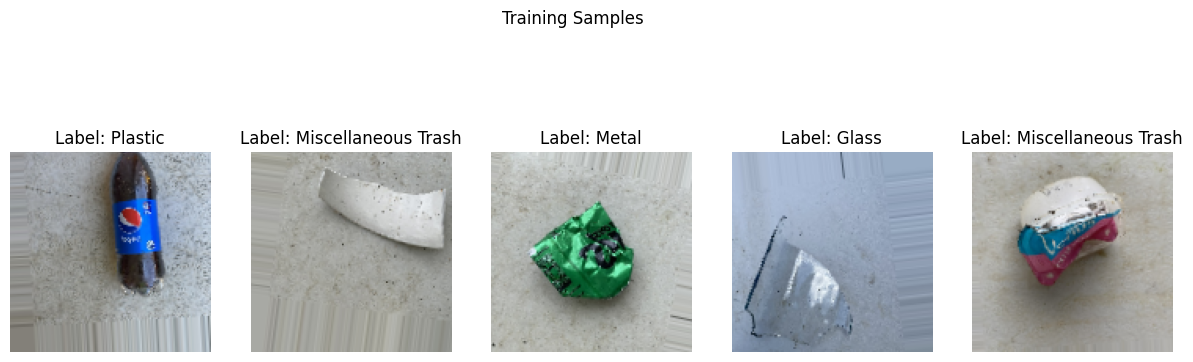

In [3]:
# Data generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255, 
    rotation_range=15, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='sparse'
)

val_data = datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='sparse'
)

test_data = datagen.flow_from_directory(
    test_dir, target_size=(128, 128), batch_size=32, class_mode='sparse', shuffle=False
)

# Class names
class_names = list(train_data.class_indices.keys())

# Plot samples
def plot_samples(data_gen, class_names, num_samples=5):
    images, labels = next(data_gen)
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {class_names[int(labels[i])]}") 
        plt.axis('off')

plot_samples(train_data, class_names, num_samples=5)
plt.suptitle('Training Samples')
plt.show()

### 3.Model Architecture

In [4]:
# Define the CNN model
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,519,241 (24.87 MB)

 Trainable params: 6,518,793 (24.87 MB)

 Non-trainable params: 448 (1.75 KB)

### 4.Train the model

In [5]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)

C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.2646 - loss: 4.3731 - val_accuracy: 0.1663 - val_loss: 9.9815
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.3262 - loss: 1.9268 - val_accuracy: 0.0916 - val_loss: 9.5298
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.3687 - loss: 1.8828 - val_accuracy: 0.0958 - val_loss: 10.7336
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.4063 - loss: 1.7388 - val_accuracy: 0.0895 - val_loss: 13.8526
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.4263 - loss: 1.6605 - val_accuracy: 0.2358 - val_loss: 4.2408
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.4209 - loss: 1.6144 - val_accuracy: 0.3147 - val_loss: 2.4839
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.4403 - loss: 1.5943 - val_accuracy: 0.3716 - val_loss: 2.8884
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.4555 - loss: 1.5484 - val_accuracy: 0.3632 - 

### 5.Evaluate the Model 

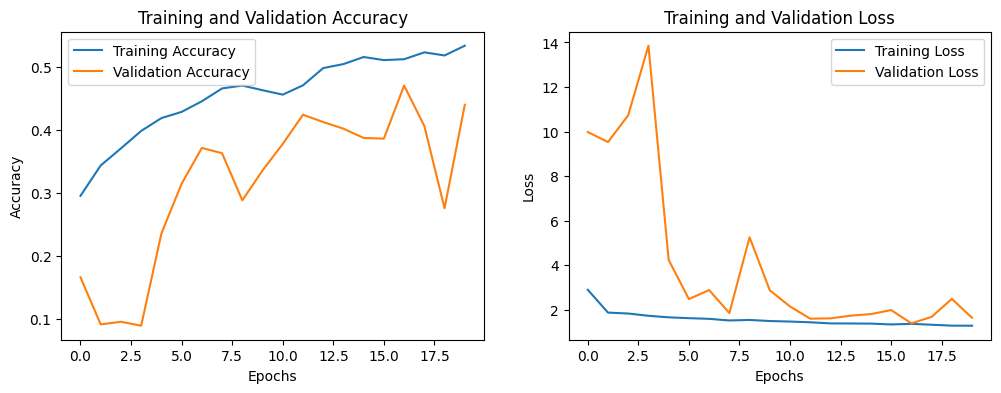

In [6]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)

In [7]:
# Evaluate model
print("\n--- Evaluation ---")
train_loss, train_acc = model.evaluate(train_data)
val_loss, val_acc = model.evaluate(val_data)
test_loss, test_acc = model.evaluate(test_data)

print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")


--- Evaluation ---
89/89 ━━━━━━━━━━━━━━━━━━━━ 48s 535ms/step - accuracy: 0.4625 - loss: 1.5171
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 524ms/step - accuracy: 0.4316 - loss: 1.6152
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 520ms/step - accuracy: 0.3751 - loss: 1.6794
Training Loss: 1.5274, Accuracy: 0.4691
Validation Loss: 1.6658, Accuracy: 0.4137
Test Loss: 1.5923, Accuracy: 0.4193


30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 521ms/step


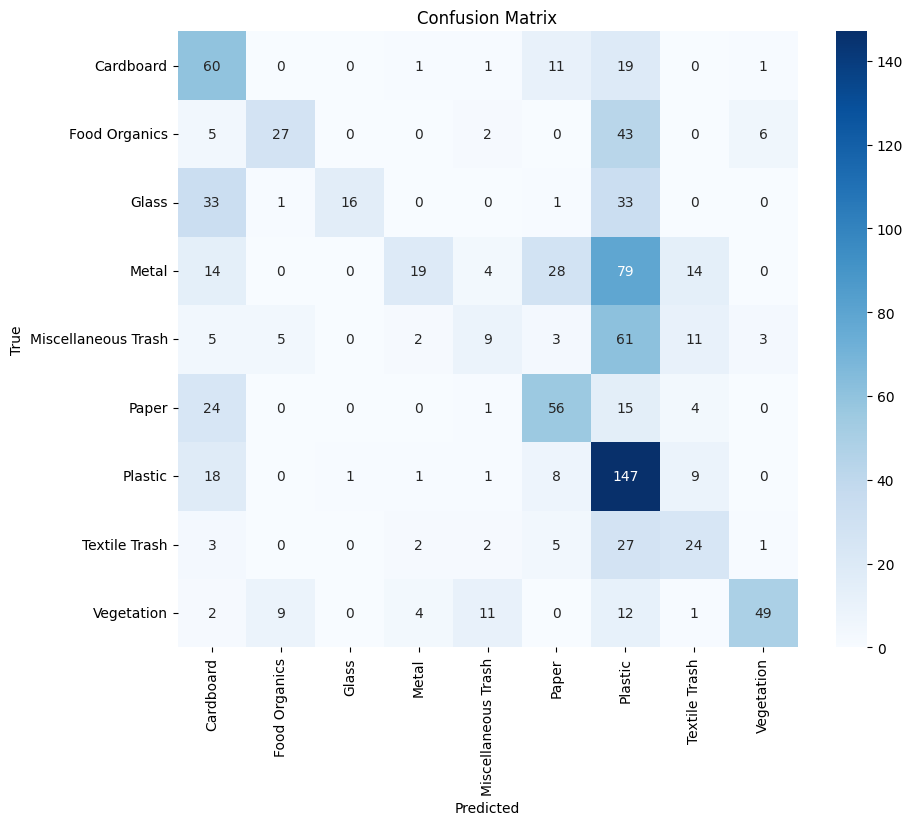


--- Classification Report ---
                     precision    recall  f1-score   support

          Cardboard       0.37      0.65      0.47        93
      Food Organics       0.64      0.33      0.43        83
              Glass       0.94      0.19      0.32        84
              Metal       0.66      0.12      0.20       158
Miscellaneous Trash       0.29      0.09      0.14        99
              Paper       0.50      0.56      0.53       100
            Plastic       0.34      0.79      0.47       185
      Textile Trash       0.38      0.38      0.38        64
         Vegetation       0.82      0.56      0.66        88

           accuracy                           0.43       954
          macro avg       0.55      0.41      0.40       954
       weighted avg       0.53      0.43      0.39       954



In [8]:
#Generate predictions
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

Training with learning rate: 0.0001

Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.5529 - loss: 1.2151 - val_accuracy: 0.5695 - val_loss: 1.1344
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.5754 - loss: 1.1239 - val_accuracy: 0.5937 - val_loss: 1.1055
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.5728 - loss: 1.1371 - val_accuracy: 0.5474 - val_loss: 1.4162
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.5899 - loss: 1.0827 - val_accuracy: 0.5747 - val_loss: 1.1194
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6084 - loss: 1.0623 - val_accuracy: 0.6042 - val_loss: 1.1190
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6023 - loss: 1.0879 - val_accuracy: 0.6232 - val_loss: 1.0416
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.6056 - loss: 1.0955 - val_accuracy: 0.5916 - val_loss: 1.2185
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6130 - loss: 1.0

89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 920ms/step - accuracy: 0.1871 - loss: 2.1485 - val_accuracy: 0.1937 - val_loss: 2.1417
Epoch 11/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 923ms/step - accuracy: 0.1839 - loss: 2.1458 - val_accuracy: 0.1937 - val_loss: 2.1420
Epoch 12/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 83s 927ms/step - accuracy: 0.1964 - loss: 2.1466 - val_accuracy: 0.1937 - val_loss: 2.1417
Epoch 13/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 81s 915ms/step - accuracy: 0.1919 - loss: 2.1377 - val_accuracy: 0.1937 - val_loss: 2.1416
Epoch 14/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 920ms/step - accuracy: 0.1977 - loss: 2.1410 - val_accuracy: 0.1937 - val_loss: 2.1417
Epoch 15/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 81s 913ms/step - accuracy: 0.1862 - loss: 2.1469 - val_accuracy: 0.1937 - val_loss: 2.1419
Epoch 16/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 81s 915ms/step - accuracy: 0.2000 - loss: 2.1362 - val_accuracy: 0.1937 - val_loss: 2.1418
Epoch 17/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 81s 913ms/step - accuracy: 0.1923 - loss: 2.1426 - val_accuracy

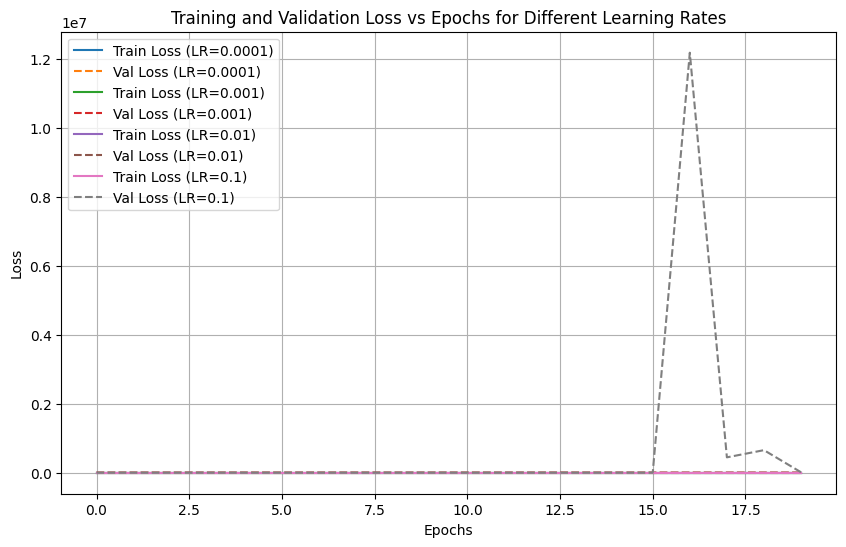

In [9]:
# Learning rates to test
learning_rates = [0.0001, 0.001, 0.01, 0.1]
history_dict = {}  # To store training history for each learning rate

# Loop over each learning rate and train the model
for lr in learning_rates:
    print(f"Training with learning rate: {lr}\n")
    
    # Compile the model with the current learning rate
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
    )
    
    # Store the history
    history_dict[lr] = history.history

# Plot training and validation loss for each learning rate
plt.figure(figsize=(10, 6))

for lr, hist in history_dict.items():
    plt.plot(hist['loss'], label=f'Train Loss (LR={lr})')
    plt.plot(hist['val_loss'], linestyle='--', label=f'Val Loss (LR={lr})')

plt.title('Training and Validation Loss vs Epochs for Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()